# Watermass transformation in MOM6
Mass transport ($G$) across a contour of a materially-conserved tracer ($\lambda$) can be derived from the integrated diffusive tendencies of that tracer ($\dot{\lambda}$). Formally, this is written
$$ G(\lambda) = \frac{\partial}{\partial \lambda}\iiint_{\lambda'\leq\lambda}\rho\dot{\lambda}dV \, .$$
This calculation, initially laid out by Walin (1982) and recently generalized in Groeskamp et al. (2019), is broadly known as watermass transformation and it can be used to reframe the ocean circulation in a new coordinate system.  

Here, we show how to carry out this calculation in MOM6 in a variety of contexts.

## Discrete formulation of watermass transformation for MOM6
For evaluation in an ocean model, we can write out a discrete version of the above equation (see Section 7.5 in Groeskamp et al., 2019):
$$ G(\lambda) = \frac{1}{\Delta\lambda}\sum_n\sum_{i,j,k}\Pi(\lambda_n,\lambda,\Delta\lambda)(\rho\dot{\lambda})_{i,j,k}V_{i,j,k} \, ,$$
where $\Delta\lambda$ is the discrete bin width for defining $\lambda$ contours, $V$ is the grid-cell volume, and we have introduced a boxcar function to accumulate grid cells in which $\lambda$ falls within the discrete bin:
$$
\Pi(\lambda_n,\lambda,\Delta\lambda) = \left\{
                \begin{array}{ll}
                  1 \quad \mathrm{if} \, \lambda_n \in [\lambda-\Delta\lambda/2,\lambda+\Delta\lambda/2] \\
                  0 \quad \mathrm{otherwise} \\
                \end{array}
              \right.
$$
Now, in the case of heat and salt in MOM6, it is the vertically-extensive tracer content that is conserved (see budget closure tutorial) and we can rewrite the discrete equation as:
$$ G(\lambda) \approx \frac{1}{\Delta\lambda}\sum_n\sum_{i,j,k}\Pi(\lambda_n,\lambda,\Delta\lambda)(\rho\dot{\Lambda})_{i,j,k}A_{i,j} \, ,$$
where $\dot{\Lambda} = \int^{z_{k-1}}_{z_k} \dot{\lambda}\,dz$ is the diffusive tendency of the vertically-integrated tracer content, and $A$ is the horizontal grid area.  

From the equation above, it becomes clear that the calculation simply involves integrating tracer tendencies in discrete bins based on their $\lambda$ value. Here, we will go through several approaches to perform this integration, specifically the accumulation of the terms into $\lambda$ bins.

## Transformation across temperature contours
In the first instance, we consider transformation across contours of constant temperature - a quantity that is materially conserved. At present, online remapping to temperature layers is not possible in MOM6, so the binning procedure has to be performed offline, *i.e.* with the saved diagnostics. Here, we show two different approaches to perform that binning: a simple histogram approach (using the `xhistogram` package), and a higher-order vertical-remapping approach (using the `xgcm` package).

As in the budget closure tutorial, we use the Baltic Sea configuration as an example case. As was confirmed in thhat tutorial, our budgets for heat, salt, and thickness close to machine precision for this configuration.

In [36]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
from xgcm import Grid

In [97]:
# Load data on native grid
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
gridname = 'native'
prefix = '19000101.ocean_'
# Diagnostics were saved into different files
suffixs = ['1900','heat','salt']
ds = xr.Dataset()
for suffix in suffixs:
    filename = prefix+gridname+'_'+suffix+'*.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
gridname = '19000101.ocean_static.nc'
grid = xr.open_dataset(rootdir+gridname).squeeze()

# Specify the diffusive tendency terms
processes=['boundary forcing','vertical diffusion','neutral diffusion','frazil ice','internal heat']
terms = {}
terms['heat'] = {'boundary forcing':'boundary_forcing_heat_tendency',
         'vertical diffusion':'opottempdiff',
         'neutral diffusion':'opottemppmdiff',
         'frazil ice':'frazil_heat_tendency',
         'internal heat':'internal_heat_heat_tendency'}
# Specify the tracer range and bin widths (\delta\lambda) for the calculation
delta_l = 0.2
lmin = -2
lmax = 10
bins = np.arange(lmin,lmax,delta_l)
# Specify constants for the reference density and the specific heat capacity
rho0 = 1035.
Cp = 3992.

#### Simple binning with `xhistogram`
For each of the diffusive heat tendencies, calculate the discrete expression of $G$ given above. The binning procedure is equivalent to applying the boxcar function and discrete summation in that expression. Note the heat tendencies need to be divided by the specific heat capacity ($c_p = 3992 \,Jkg^{-1}K^{-1}$) to convert them to a tendency in vertically-integrated temperature.

The usage of `xhistogram` is ```histogram(variable(s), bins, dim, weights)``` in which `variables` is the tracer defining the layers ($\lambda$, or here temperature), `bins` defines the layer boundaries, `dim` is the dimensions over which to integrate, and `weights` defines the multiplier for each point in the histogram. It is the `weights` parameter that we use to specify the *integrand* in the calculation of $G$, i.e. $\rho\dot{\Lambda}A$.

The histogram procedure provides the integrated tendencies between two temperature contours (or $\lambda$ contours in general). Thus, when divided by the temperature bin width, this gives the approximate transformation across the central contour of that layer.

In [98]:
G = xr.Dataset()
for process in processes:
    term = terms['heat'][process]
    nanmask = np.isnan(ds[term])
    G[process] = histogram(ds['temp'].where(~nanmask).squeeze(),
                        bins=[bins],
                        dim=['xh','yh','zl'],
                        weights=(rho0*(ds[term]/Cp)*grid['areacello']).where(~nanmask).squeeze())/np.diff(bins)

Text(0, 0.5, 'Transformation [$kg\\,s^{-1}$]')

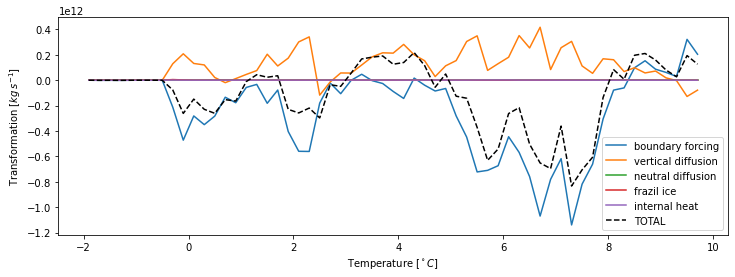

In [99]:
# Plot the time-mean transformation
fig, ax = plt.subplots(figsize=(12,4))
total = xr.zeros_like(G[processes[0]].mean('time'))
for process in processes:
    ax.plot(G['temp_bin'],G[process].mean('time'),label=process)
    total += G[process].mean('time')
ax.plot(G['temp_bin'],total,color='k',linestyle='--',label='TOTAL')
ax.legend()
ax.set_xlabel('Temperature [$^\circ C$]')
ax.set_ylabel('Transformation [$kg\,s^{-1}$]')

We can see that, as we might expect, boundary forcing dominates transformation over the course of a month, and is partially compensated by vertical diffusion.  

Binning with `xhistogram` provides a really straightforward and efficient way perform the watermass transformation calculation. `xhistogram` is set up to work with `dask`, so can be effectively scaled to process large amounts of model data efficiently. However, such a basic binning procedure on offline data is constrained by the vertical resolution of the output data. This can be problematic for two reasons: (1) if a $\lambda$ changes by more than $\Delta\lamda$ in the vertical over one grid cell, a layer will appear to be missing at that point; and (2) tendencies from a grid cell can be placed into one layer or another, but cannot be split between two, resulting in a definition of the $\lambda$ contour that is prone to be noisy and poorly defined. This can lead to noisiness, data gaps and inaccuracy in our calculation, and strong lower limit on $\Delta\lambda$ such that the approximation of $G$ cannot converge.

It would be altogether preferable if we could delineate and bin the output tendencies based on a $\lambda$ field that is continuously defined. For this, we turn to `xgcm`.

#### Conservative remapping with `xgcm.transform`

[Under construction]

In [100]:
# Build an xgcm grid object
# Create a pseudo-grid in the vertical
grid['zl'] = ds['zl']
grid['zi'] = ds['zi']
grid['dzt'] = grid['zl'].copy(data=grid['zi'].diff('zi'))
grid = grid.squeeze() # Get rid of any remnant time variables

# Fill in nans with zeros
grid['dxt'] = grid['dxt'].fillna(0.)
grid['dyt'] = grid['dyt'].fillna(0.)
grid['dzt'] = grid['dzt'].fillna(0.)
grid['areacello'] = grid['areacello'].fillna(0.)
grid['volcello'] = (ds['thkcello']*grid['areacello']).fillna(0.)
metrics = {
    ('X',): ['dxt','dxCu','dxCv'], # X distances
    ('Y',): ['dyt','dyCu','dyCv'], # Y distances
    ('Z',): ['dzt'], # Z distances
    ('X', 'Y'): ['areacello'], # Areas
    ('X', 'Y', 'Z'): ['volcello'], # Volumes
}
coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
        'Z': {'center': 'zl', 'outer': 'zi'} }
xgrid = Grid(grid, coords=coords, metrics=metrics, periodic=['X'])

# Interpolate the temperature coordinate to the cell interfaces
ds['temp_i'] = xgrid.interp(ds['temp'],'Z',boundary='extrapolate').chunk({'zi':-1})

In [101]:
# Transform each of the diffusive tendency terms onto a temperature grid
# And integrate in each temperature layer and divide by \delta temp
G = xr.Dataset()
for process in processes:
    term = terms['heat'][process]
    var_on_temp = xgrid.transform(ds[term],'Z',target=bins,target_data=ds['temp_i'],method='conservative')
    G[process] = ((rho0*var_on_temp/Cp)*grid['areacello']).sum(['xh','yh'])/np.diff(bins)

Text(0, 0.5, 'Transformation [$kg\\,s^{-1}$]')

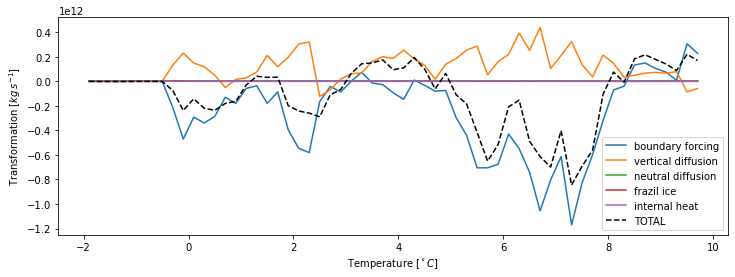

In [102]:
fig, ax = plt.subplots(figsize=(12,4))
total = xr.zeros_like(G[processes[0]].mean('time'))
for process in processes:
    ax.plot(G['temp_i'],G[process].mean('time'),label=process)
    total += G[process].mean('time')
ax.plot(G['temp_i'],total,color='k',linestyle='--',label='TOTAL')
ax.legend()
ax.set_xlabel('Temperature [$^\circ C$]')
ax.set_ylabel('Transformation [$kg\,s^{-1}$]')

## Transformation across $\rho_2$ contours
MOM6 has the functionality to output diagnostics on a user-defined $\rho_2$ grid (note that budgets of heat and salt remain closed on this grid, see budget closure tutorial). This is equivalent to the binning procedures performed above being done *online*, thus reducing the possibility for errors due to time averaging.  

However, $\rho_2$ is not a materially-conserved quantity, so transformation evaluated across its contours will always be approximate. In practice, the challenge arises because a diffusive tendency is only well-defined for the locally-referenced potential density ($\rho_l$), which cannot be directly related to the potential density referenced to $2000\,m$ ($\rho_2$). In a separate tutorial, we go through the procedure of calculating transformation across contours of the best approximation of a materially-conserved density variable, neutral density, which involves a correction for its discrepancy to $\rho_l$.  

Here, we evaluate transformation across $\rho_2$ contours using tendencies in $\rho_l$ without attempting to apply any correction, simply to show the procedure applied to an online-binned variable.

In [103]:
# Load data on the rho2 grid
gridname = 'rho2'
ds = xr.Dataset()
for suffix in suffixs:
    filename = prefix+gridname+'_'+suffix+'*.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])

# Define the salt tendency terms
terms['salt'] = {'boundary forcing':'boundary_forcing_salt_tendency',
         'vertical diffusion':'osaltdiff',
         'neutral diffusion':'osaltpmdiff',
         'frazil ice':None,
         'internal heat':None}

In [111]:
# Define a short function to calculate the tendency
# of the locally-referenced potential density
# from heat and salt content tendencies
def densitytendency_from_heat_and_salt(heat_tend,salt_tend,alpha=1E-4,beta=1E-3,Cp=3992.0):
    densitytendency_heat = (alpha/Cp)*heat_tend
    densitytendency_salt = beta*salt_tend*1000 # Factor of 1000 converts salt_tend to g m-2 s-1
    densitytendency = densitytendency_heat + densitytendency_salt
    return densitytendency, densitytendency_heat, densitytendency_salt

In [114]:
drhodt = xr.Dataset()
drhodt_heat = xr.Dataset()
drhodt_salt = xr.Dataset()
for process in processes:
    print(process)
    term_heat = terms['heat'][process]
    term_salt = terms['salt'][process]
    
    # If there is no contribution of heat or salt for this process,
    # set to zero. A little hacky, requiring that the first process
    # is non-zero for both heat and salt.
    if term_heat is not None:
        heat_tend = ds[term_heat]
    else:
        heat_tend = xr.zeros_like(ds[terms['heat'][processes[0]]])
        
    if term_salt is not None:
        salt_tend = ds[term_salt]
    else:
        salt_tend = xr.zeros_like(ds[terms['salt'][processes[0]]])
        
    drhodt[process], drhodt_heat[process], drhodt_salt[process] = densitytendency_from_heat_and_salt(heat_tend,
                                                                  salt_tend,
                                                                  alpha=ds['drho_dT'],
                                                                  beta=ds['drho_dS'],Cp=Cp)

boundary forcing
vertical diffusion
neutral diffusion
frazil ice
internal heat


In [119]:
# Calculate G by integrating within each density layer
# In this case, the bins are defined by the rho2 grid
G = xr.Dataset()
for process in processes:
    G[process] = ((rho0*drhodt[process])*grid['areacello']).sum(['xh','yh'])/np.diff(ds['rho2_i'])

Text(0, 0.5, 'Transformation [$kg\\,s^{-1}$]')

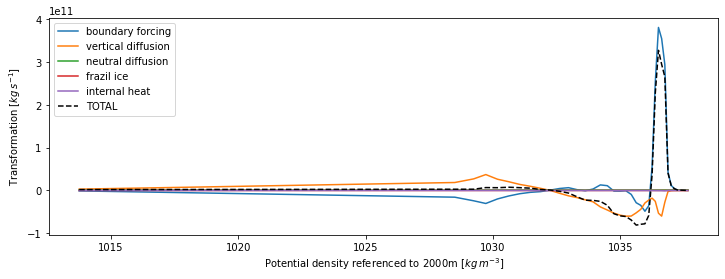

In [121]:
fig, ax = plt.subplots(figsize=(12,4))
total = xr.zeros_like(G[processes[0]].mean('time'))
for process in processes:
    ax.plot(G['rho2_l'],G[process].mean('time'),label=process)
    total += G[process].mean('time')
ax.plot(G['rho2_l'],total,color='k',linestyle='--',label='TOTAL')
ax.legend()
ax.set_xlabel('Potential density referenced to 2000m [$kg\,m^{-3}$]')
ax.set_ylabel('Transformation [$kg\,s^{-1}$]')

## Closing the mass budget within layers
The transformation $G$ represents a mass flux across layers of constant $\lambda$. For a time-varying system within a fixed region ($\mathscr{R}$) with boundaries in the ocean interior ($\partial\mathscr{R}_{int}$) and at the ocean surface ($\delta\mathscr{R}_{surf}$), $G$ will be balanced by temporal mass changes and mass transport across the fixed boundaries (see Section 2.3 in Groeskamp et al., 2019):
$$ G = -\frac{dM}{dt} - \psi + W $$
where
$$M = \iiint_{\mathscr{R}(\lambda'\leq\lambda)} \rho dV\,; \quad \psi = \iint_{\partial\mathscr{R}_{int}(\lambda'\leq\lambda)} (\rho\mathbf{u})\cdot\mathbf{\hat{n}}dR\,; \quad W = \iint_{\partial\mathscr{R}_{surf}(\lambda'\leq\lambda)} \rho F dR\,,$$
are, respectively, the total mass in the region, the mass flux across the interior ocean boundary ($\mathbf{\hat{n}}$ is normal to the boundary), and the mass flux across the ocean surface ($F$ is the local balance of air-sea and ice-sea volume fluxes).

In [120]:
G

<xarray.Dataset>
Dimensions:             (rho2_l: 35, time: 12)
Coordinates:
  * rho2_l              (rho2_l) float64 1.014e+03 1.028e+03 ... 1.038e+03
  * time                (time) object 1900-01-16 12:00:00 ... 1900-12-16 12:0...
Data variables:
    boundary forcing    (time, rho2_l) float64 dask.array<chunksize=(1, 35), meta=np.ndarray>
    vertical diffusion  (time, rho2_l) float64 dask.array<chunksize=(1, 35), meta=np.ndarray>
    neutral diffusion   (time, rho2_l) float64 dask.array<chunksize=(1, 35), meta=np.ndarray>
    frazil ice          (time, rho2_l) float64 dask.array<chunksize=(1, 35), meta=np.ndarray>
    internal heat       (time, rho2_l) float64 dask.array<chunksize=(1, 35), meta=np.ndarray>